In [1]:
# setup random indicies
import numpy as np

np.random.seed(9)

house_ids = range(1,1461)
random_id = np.random.choice(house_ids, 1460, replace = False)


# load df
import pandas as pd
df = pd.read_csv("../../data/train_model.csv")

# randomized index
df.drop(columns = ['Unnamed: 0', 'Id'], inplace = True)
df['random_id'] = random_id
df.set_index('random_id', inplace = True)
df.sort_index(inplace=True)
df.head(5)

# remove outliers
df.drop([907, 465], inplace=True)

# log transform SalePrice
df['SalePrice'] = np.log(df.SalePrice)

df.head(5)

,LotFrontage,LotArea,YearBuilt,GrLivArea,YrSold,SalePrice,MSZoning_RL,MSZoning_RMH,Alley_NoAccess,LotShape_Regular,...,OpenPorchSF_OpenPorch_Yes,Fence_no_fence,MoSold_peak_months,SaleType_non_deed,SaleCondition_not_normal,IsVinyl_yes,FullBaths_<=1FullBath,FullBaths_>=3FullBaths,HalfBaths_>=1HalfBaths,Enclosed_combined_EnclosedPorch_Yes
random_id,,,,,,,,,,,,,,,,,,,,,
1,87.0,9246,37,1656,2008,11.813030,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
2,60.0,7200,60,1904,2009,11.835009,1,0,1,1,...,0,0,1,0,0,1,0,0,1,1
3,74.0,8532,56,1297,2009,11.938193,1,0,1,1,...,0,1,0,0,0,0,1,0,1,0
4,47.0,53504,7,3279,2010,13.195614,1,0,1,0,...,1,1,1,0,0,0,0,1,1,1
5,82.0,9430,11,2365,2009,12.727838,1,0,1,1,...,1,1,1,0,0,1,0,1,1,1


In [2]:
test_1 = df.iloc[0:292,:]
test_2 = df.iloc[292:584,:]
test_3 = df.iloc[584:876,:]
test_4 = df.iloc[876:1168,:]
test_5 = df.iloc[1168:1460,:]
print(len(test_1))
print(len(test_2))
print(len(test_3))
print(len(test_4))
print(len(test_5)) # note 2 fewer due to dropped outliers above

292
292
292
292
290


In [3]:
group_test = test_1.copy()
group_train = pd.concat([test_2, test_3, test_4, test_5])

x_grouptrain = group_train.loc[:, group_train.columns != 'SalePrice']
y_grouptrain = group_train['SalePrice']

x_grouptest = group_test.loc[:, group_test.columns != 'SalePrice']
y_grouptest = group_test['SalePrice']

group_train.shape
#group_train.head(5)

(1166, 70)

In [4]:
p_test = test_2.copy()
p_train = pd.concat([test_1, test_3, test_4, test_5])

x_ptrain = p_train.loc[:, p_train.columns != 'SalePrice']
y_ptrain = p_train['SalePrice']

x_ptest = p_test.loc[:, p_test.columns != 'SalePrice']
y_ptest = p_test['SalePrice']

p_train.shape
#p_train.head(5)

(1166, 70)

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [6]:
x_df = df.loc[:, df.columns != 'SalePrice']
y_df = df['SalePrice']

In [7]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
x = sm.add_constant(x_df)
y = y_df
model_fit = sm.OLS(y, x).fit()
#print(model_fit.summary())

/Users/mymacpro/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

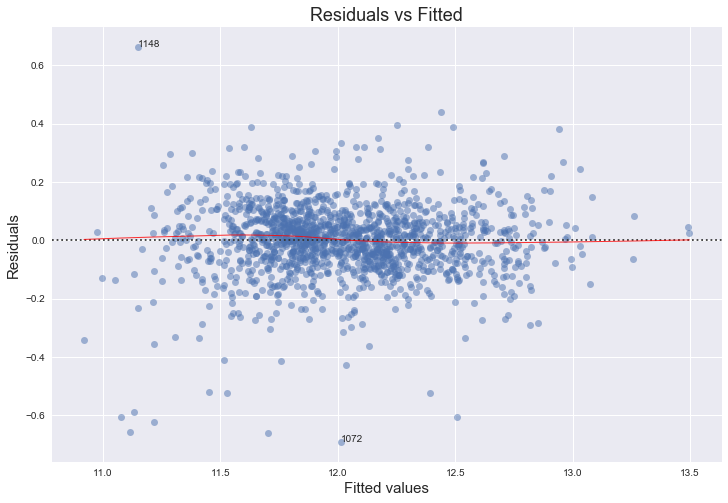

In [9]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'SalePrice',data=df, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

#annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:2]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

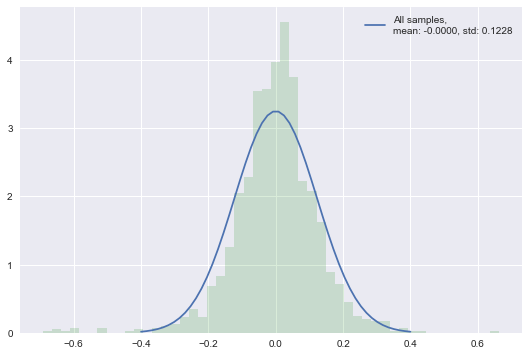

In [10]:
from scipy import stats
plt.figure(figsize=(9, 6))
#plt.xlim(-0.4, 0.4)
#plt.ylim(0, 4.3)
plt.hist(model_residuals, color='green', bins=50, normed=True, alpha=0.15)
my_norm = stats.norm(np.mean(model_residuals), np.std(model_residuals)).pdf
label = 'All samples,\nmean: %.4f, std: %.4f' % (np.mean(model_residuals), np.std(model_residuals))
plt.plot(np.linspace(-0.4, 0.4), my_norm(np.linspace(-0.4, 0.4)), label=label)
plt.legend()
plt.show()

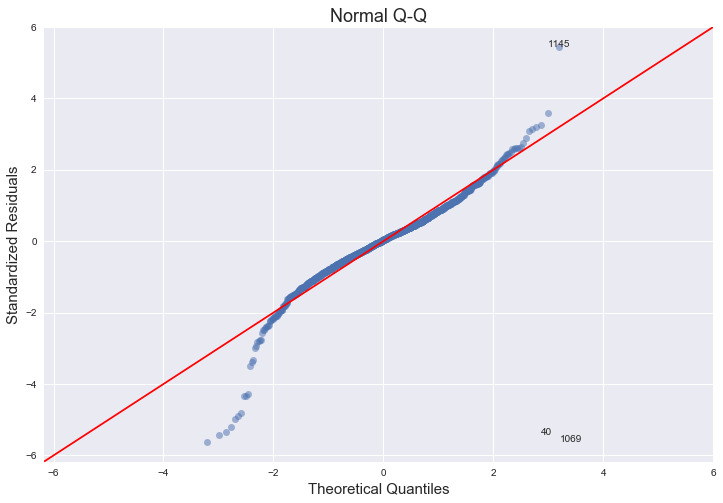

In [11]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

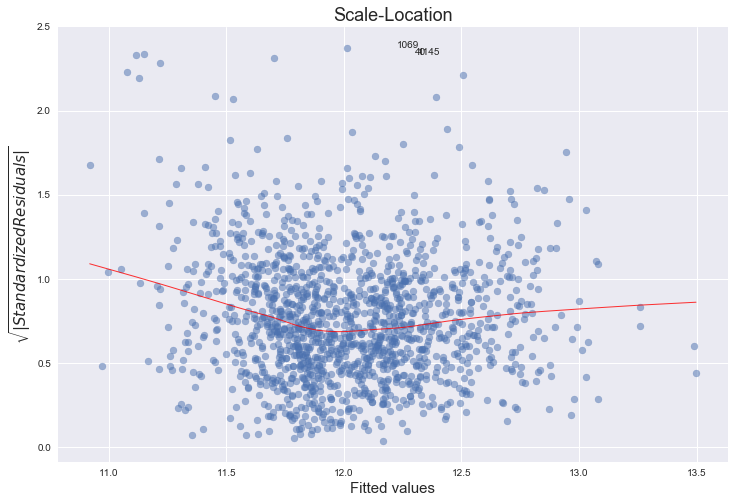

In [12]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

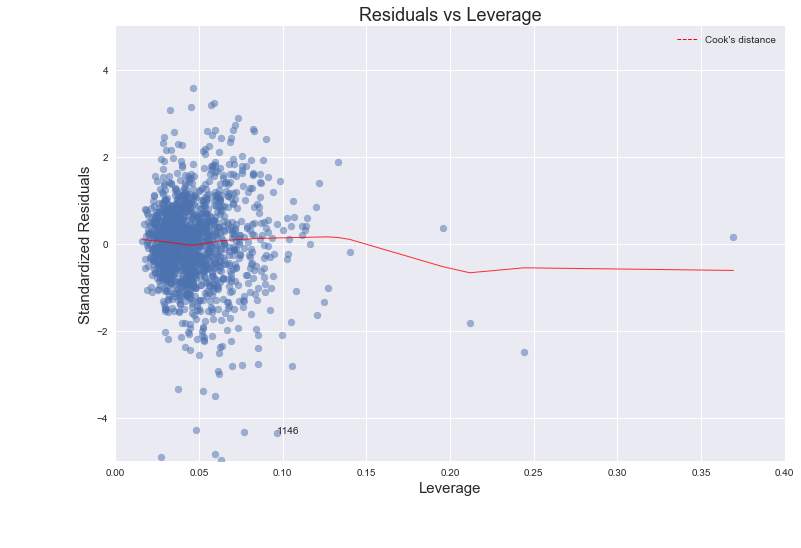

In [13]:
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.4)
plot_lm_4.axes[0].set_ylim(-5, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model_fit.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.Series([variance_inflation_factor(x_df.values, i) for i in range(x_df.shape[1])], index = x_df.columns)
vif[vif>5]

YearBuilt                   6.907783e+00
GrLivArea                   5.185768e+00
MSZoning_RL                 5.185523e+00
MSZoning_RMH                5.096500e+00
BldgType_OneFamily          8.757272e+00
BldgType_Townhouse          7.715486e+00
GarageFinish_NoGarageFin    1.372109e+05
GarageCars_1                6.249899e+05
GarageCars_2                1.393827e+06
GarageCars_AtLeast3         3.132713e+05
dtype: float64

In [15]:
corr_matrix = df.corr()
corr = corr_matrix['SalePrice'].sort_values(ascending=False)
corr[abs(corr)>0.4]

SalePrice                    1.000000
GrLivArea                    0.725211
OverallQual_HighQ            0.609127
Foundation_pconc             0.531193
GarageCars_AtLeast3          0.524713
FullBaths_>=3FullBaths       0.519374
Neighborhood_NAmes           0.503646
OpenPorchSF_OpenPorch_Yes    0.449388
KitchenQual_ExKtchnQ         0.417469
KitchenQual_GdKtchnQ         0.406886
GarageCars_1                -0.425588
OverallQual_LowQ            -0.429371
GarageFinish_GarageUnf      -0.432143
FullBaths_<=1FullBath       -0.493877
Fireplaces_NoFireplace      -0.510253
GarageType_Detached         -0.537854
BsmtQual_low                -0.586562
YearBuilt                   -0.587043
ExterQual_low               -0.635358
Name: SalePrice, dtype: float64

## Model

### Group Model

In [16]:
# x_group = sm.add_constant(x_grouptrain)
# y_group = y_grouptrain
# model_group = sm.OLS(y_group, x_group).fit()
# #print(model_fit.summary())

In [17]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(x_grouptrain, y_grouptrain)
print("Group Model")
print(10*"~")
print("Train RSS: %.2f" % np.sum(((y_grouptrain) - (ols.predict(x_grouptrain))) ** 2))
print("Train MSE: %.3f" % (np.sum(((y_grouptrain) - (ols.predict(x_grouptrain))) ** 2)/len(y_grouptrain)))
print("Train RMSE: %.4f" % np.sqrt(np.sum(((y_grouptrain) - (ols.predict(x_grouptrain))) ** 2)/len(y_grouptrain)))
#print("Intercept: %f" %ols.intercept_)
#print("Coefficients: %s" %str(ols.coef_))
print("Train R^2: %f" %(ols.score(x_grouptrain, y_grouptrain)))
print(10*"~")
print("Test RSS: %.2f" % np.sum(((y_grouptest) - (ols.predict(x_grouptest))) ** 2))
print("Test MSE: %.3f" % (np.sum(((y_grouptest) - (ols.predict(x_grouptest))) ** 2)/len(y_grouptest)))
print("Test RMSE: %.4f" % np.sqrt(np.sum(((y_grouptest) - (ols.predict(x_grouptest))) ** 2)/len(y_grouptest)))
print("Test R^2: %f" %(ols.score(x_grouptest, y_grouptest)))

Group Model
~~~~~~~~~~
Train RSS: 16.80
Train MSE: 0.014
Train RMSE: 0.1200
Train R^2: 0.906910
~~~~~~~~~~
Test RSS: 6.32
Test MSE: 0.022
Test RMSE: 0.1471
Test R^2: 0.878756


### Phoebe Model

In [18]:
P_ols = LinearRegression()
P_ols.fit(x_ptrain, y_ptrain)
print("Phoebe Model")
print(10*"~")
print("Train RSS: %.2f" % np.sum(((y_ptrain) - (P_ols.predict(x_ptrain))) ** 2))
print("Train RMSE: %.4f" % np.sqrt(np.sum(((y_ptrain) - (ols.predict(x_ptrain))) ** 2)/len(y_ptrain)))
print("Train RMSE: %.4f" % np.sqrt(np.sum(((y_ptrain) - (P_ols.predict(x_ptrain))) ** 2)/len(y_ptrain)))
#print("Intercept: %f" %ols.intercept_)
#print("Coefficients: %s" %str(ols.coef_))
print("Train R^2: %f" %(P_ols.score(x_ptrain, y_ptrain)))
print(10*"~")
print("Test RSS: %.2f" % np.sum(((y_ptest) - (P_ols.predict(x_ptest))) ** 2))
print("Test MSE: %.3f" % (np.sum(((y_ptest) - (P_ols.predict(x_ptest))) ** 2)/len(y_ptest)))
print("Test RMSE: %.4f" % np.sqrt(np.sum(((y_grouptest) - (P_ols.predict(x_ptest))) ** 2)/len(y_ptest)))
print("Test R^2: %f" %(P_ols.score(x_ptest, y_ptest)))

Phoebe Model
~~~~~~~~~~
Train RSS: 18.48
Train RMSE: 0.1309
Train RMSE: 0.1259
Train R^2: 0.902363
~~~~~~~~~~
Test RSS: 3.84
Test MSE: 0.013
Test RMSE: 0.5584
Test R^2: 0.911066


In [19]:
# feature selection
import sklearn.feature_selection as fs
import pprint
print('Shape: (%d, %d)' %p_train.shape)
print('Variation:')
pprint.pprint(dict(zip(p_train.columns, np.var(p_train, 0))))

Shape: (1166, 70)
Variation:
{'Alley_NoAccess': 0.0609316570998168,
 'BedroomAbvGr_=3Bedr': 0.24608033799269696,
 'BedroomAbvGr_>=4Bedr': 0.13581860548590946,
 'BldgType_OneFamily': 0.1311347233949898,
 'BldgType_Townhouse': 0.09095910723794892,
 'BsmtCond_low': 0.04649532641538894,
 'BsmtExposure_no_exposure': 0.2234472136491594,
 'BsmtFinType1_undeveloped': 0.22482634036405774,
 'BsmtQual_low': 0.24976168690366563,
 'CentralAir_NoCentAir': 0.06242037841765878,
 'Condition1_NormP': 0.10369046953564381,
 'Electrical_StdCBrkr': 0.07698395652698384,
 'Enclosed_combined_EnclosedPorch_Yes': 0.18424250269940715,
 'ExterCond_low': 0.09300462798148618,
 'ExterQual_low': 0.2338888578329952,
 'Fence_no_fence': 0.1498489212654704,
 'FireplaceQu_OthFireplace': 0.2002778848388681,
 'Fireplaces_NoFireplace': 0.24899305361455976,
 'Foundation_pconc': 0.24752566278991048,
 'FullBaths_<=1FullBath': 0.1877142243497111,
 'FullBaths_>=3FullBaths': 0.18157692658485577,
 'Functional_TypFunc': 0.06018508983

In [20]:
# select according to variance threshold
select = fs.VarianceThreshold(threshold = 1).fit_transform(df)
print(select.shape)

(1458, 5)


In [21]:
# a = zip(x_ptrain.iloc[0,:],x_ptrain.columns)
# for t in a:
#     print(t)

In [22]:
# select according to f regression
best20 = fs.SelectKBest(fs.f_regression, k=20).fit_transform(x_ptrain, y_ptrain)
x_ptrain.columns[fs.SelectKBest(fs.f_regression, k=10).fit(x_ptrain, y_ptrain).get_support()]

Index(['YearBuilt', 'GrLivArea', 'OverallQual_HighQ', 'ExterQual_low',
       'Foundation_pconc', 'BsmtQual_low', 'GarageType_Detached',
       'GarageCars_AtLeast3', 'FullBaths_<=1FullBath',
       'FullBaths_>=3FullBaths'],
      dtype='object')

### other